# Data download

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
df = pd.read_csv("Google/google_stock_price.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))

<class 'pandas.core.frame.DataFrame'>
Index: 4842 entries, 2004/8/19 to 2023/11/10
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4842 non-null   float64
 1   high       4842 non-null   float64
 2   low        4842 non-null   float64
 3   close      4842 non-null   float64
 4   Adj Close  4842 non-null   float64
 5   volume     4842 non-null   int64  
 6   symbol     4842 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 302.6+ KB

number of different stocks:  1


In [3]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .9 ))

training_data_len

4358

In [4]:

df['predicted_close'] = df['close'].rolling(window=60).mean()  
df['residual'] = df['close'] - df['predicted_close']

df = df.dropna()

residual_data = df.filter(['residual'])

residual_dataset = residual_data.values

train_data = residual_dataset[:training_data_len]
test_data = residual_dataset[training_data_len - 60:] 

In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[5.54601411e-05],
       [1.39474256e-03],
       [1.57790515e-03],
       ...,
       [8.82274792e-01],
       [8.71682346e-01],
       [8.87672265e-01]])

In [6]:
# Create the training data set 
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([5.54601411e-05, 1.39474256e-03, 1.57790515e-03, 8.16681842e-04,
       1.00656502e-03, 1.32752381e-03, 1.03177125e-03, 3.36085744e-04,
       3.96579090e-04, 4.03331883e-05, 2.52062301e-04, 0.00000000e+00,
       2.63827350e-04, 3.84818859e-04, 3.86498202e-04, 8.93979878e-04,
       1.25862571e-03, 1.92911142e-03, 2.01480938e-03, 2.34584745e-03,
       2.93735417e-03, 3.25158754e-03, 2.99616656e-03, 3.08690416e-03,
       3.49692925e-03, 3.33056653e-03, 3.06674561e-03, 4.51189259e-03,
       5.22102410e-03, 4.97232210e-03, 5.47308479e-03, 5.88982081e-03,
       6.44603560e-03, 6.22926686e-03, 6.52669393e-03, 6.33849171e-03,
       5.92343341e-03, 6.28303961e-03, 6.87117960e-03, 7.05602154e-03,
       7.41058810e-03, 8.25919515e-03, 8.05418662e-03, 6.80228151e-03,
       8.29616160e-03, 1.21695001e-02, 1.46850625e-02, 1.37440385e-02,
       1.44447685e-02, 1.56765022e-02, 1.52295171e-02, 1.61352524e-02,
       1.59403296e-02, 1.54025956e-02, 1.42313536e-02, 1.16519311e-02,
     

In [7]:
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# RNN

In [31]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# 初始化 RNN 模型
rnn_model = Sequential()

# 添加 RNN 层
rnn_model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
rnn_model.add(SimpleRNN(64))

# 添加输出层
rnn_model.add(Dense(25))
rnn_model.add(Dense(1))

# 编译模型
rnn_model.compile(optimizer='adam', loss='mean_squared_error')


In [32]:
rnn_model.fit(x_train, y_train, batch_size=32, epochs=10)

rnn_predictions = rnn_model.predict(x_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions) 

# RMSE
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))

# MAE
rnn_mae = mean_absolute_error(y_test, rnn_predictions)

# MAPE
rnn_mape = np.mean(np.abs((y_test - rnn_predictions) / y_test)) * 100

# R^2 Score
rnn_r2 = r2_score(y_test, rnn_predictions)

print(f'RNN Model Performance:')
print(f'RMSE: {rnn_rmse}')
print(f'MAE: {rnn_mae}')
print(f'MAPE: {rnn_mape}%')
print(f'R^2 Score: {rnn_r2}')


Epoch 1/10
135/135 [==============================] - 3s 14ms/step - loss: 0.0166
Epoch 2/10
135/135 [==============================] - 2s 13ms/step - loss: 1.5407e-04
Epoch 3/10
135/135 [==============================] - 2s 13ms/step - loss: 1.2216e-04
Epoch 4/10
135/135 [==============================] - 2s 13ms/step - loss: 1.0492e-04
Epoch 5/10
135/135 [==============================] - 2s 13ms/step - loss: 8.2583e-05
Epoch 6/10
135/135 [==============================] - 2s 13ms/step - loss: 8.3468e-05
Epoch 7/10
135/135 [==============================] - 2s 13ms/step - loss: 7.5456e-05
Epoch 8/10
135/135 [==============================] - 2s 13ms/step - loss: 6.7887e-05
Epoch 9/10
135/135 [==============================] - 2s 13ms/step - loss: 6.8697e-05
Epoch 10/10
16/16 [==============================] - 0s 5ms/step
RNN Model Performance:
RMSE: 4.185162539301616
MAE: 3.3221112269118835
MAPE: 2.9351071629502137%
R^2 Score: 0.9364308096147055


In [33]:
rnn_model.fit(x_train, y_train, batch_size=32, epochs=10)

rnn_predictions = rnn_model.predict(x_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)  

# RMSE
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))

# MAE
rnn_mae = mean_absolute_error(y_test, rnn_predictions)

# MAPE
rnn_mape = np.mean(np.abs((y_test - rnn_predictions) / y_test)) * 100

# R^2 Score
rnn_r2 = r2_score(y_test, rnn_predictions)

print(f'RNN Model Performance:')
print(f'RMSE: {rnn_rmse}')
print(f'MAE: {rnn_mae}')
print(f'MAPE: {rnn_mape}%')
print(f'R^2 Score: {rnn_r2}')


Epoch 1/10
135/135 [==============================] - 2s 13ms/step - loss: 5.2177e-05
Epoch 2/10
135/135 [==============================] - 2s 13ms/step - loss: 6.3953e-05
Epoch 3/10
135/135 [==============================] - 2s 13ms/step - loss: 5.9937e-05
Epoch 4/10
135/135 [==============================] - 2s 13ms/step - loss: 6.2671e-05
Epoch 5/10
135/135 [==============================] - 2s 13ms/step - loss: 5.8711e-05
Epoch 6/10
135/135 [==============================] - 2s 13ms/step - loss: 9.0992e-05
Epoch 7/10
135/135 [==============================] - 2s 13ms/step - loss: 6.1122e-05
Epoch 8/10
135/135 [==============================] - 2s 13ms/step - loss: 5.7064e-05
Epoch 9/10
135/135 [==============================] - 2s 13ms/step - loss: 5.9406e-05
Epoch 10/10
16/16 [==============================] - 0s 5ms/step
RNN Model Performance:
RMSE: 5.444960156568125
MAE: 4.760686151705514
MAPE: 4.121579602485801%
R^2 Score: 0.8924002074818718


## LSTM

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
135/135 [==============================] - 8s 35ms/step - loss: 0.0024
Epoch 2/10
135/135 [==============================] - 5s 36ms/step - loss: 1.0837e-04
Epoch 3/10
135/135 [==============================] - 5s 35ms/step - loss: 1.0272e-04
Epoch 4/10
135/135 [==============================] - 5s 35ms/step - loss: 1.7370e-04
Epoch 5/10
135/135 [==============================] - 5s 34ms/step - loss: 1.2713e-04
Epoch 6/10
135/135 [==============================] - 5s 35ms/step - loss: 1.2111e-04
Epoch 7/10
135/135 [==============================] - 5s 34ms/step - loss: 1.0552e-04
Epoch 8/10
135/135 [==============================] - 5s 34ms/step - loss: 1.0378e-04
Epoch 9/10
135/135 [==============================] - 5s 34ms/step - loss: 9.9004e-05
Epoch 10/10
135/135 [==============================] - 5s 34ms/step - loss: 7.3768e-05


In [25]:

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(np.square(predictions - y_test)))

# MAE
mae = mean_absolute_error(y_test, predictions)

# MAPE
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# R^2 Score
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R^2 Score: {r2}')


16/16 [==============================] - 1s 13ms/step
RMSE: 4.249889105258754
MAE: 3.350977716398865
MAPE: 2.9363296312815272%
R^2 Score: 0.9344493175665267


## GRU1

In [26]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(x_train, y_train, batch_size=32, epochs=10)

# Assuming x_test and y_test are already defined and properly shaped for the GRU model

# Predict the residuals
predicted_residuals_gru = gru_model.predict(x_test)

predicted_residuals_gru = scaler.inverse_transform(predicted_residuals_gru.reshape(-1, 1))

# Calculate the performance metrics for the predicted residuals
rmse_gru = np.sqrt(np.mean(np.square(predicted_residuals_gru - y_test)))
mae_gru = mean_absolute_error(y_test, predicted_residuals_gru)
mape_gru = np.mean(np.abs((y_test - predicted_residuals_gru) / y_test)) * 100
r2_gru = r2_score(y_test, predicted_residuals_gru)

# Print the performance metrics
print(f'GRU Model Performance:')
print(f'RMSE: {rmse_gru}')
print(f'MAE: {mae_gru}')
print(f'MAPE: {mape_gru}%')
print(f'R^2 Score: {r2_gru}')

Epoch 1/10
135/135 [==============================] - 6s 28ms/step - loss: 0.0016
Epoch 2/10
135/135 [==============================] - 4s 28ms/step - loss: 5.1471e-05
Epoch 3/10
135/135 [==============================] - 4s 28ms/step - loss: 4.3388e-05
Epoch 4/10
135/135 [==============================] - 4s 28ms/step - loss: 4.3795e-05
Epoch 5/10
135/135 [==============================] - 4s 28ms/step - loss: 4.8304e-05
Epoch 6/10
135/135 [==============================] - 4s 28ms/step - loss: 4.3722e-05
Epoch 7/10
135/135 [==============================] - 4s 28ms/step - loss: 4.3525e-05
Epoch 8/10
135/135 [==============================] - 4s 28ms/step - loss: 3.9037e-05
Epoch 9/10
135/135 [==============================] - 4s 28ms/step - loss: 4.1059e-05
Epoch 10/10
16/16 [==============================] - 1s 9ms/step
GRU Model Performance:
RMSE: 3.133196601204743
MAE: 2.486603380966031
MAPE: 2.1451107090174055%
R^2 Score: 0.9643715183231534


## GRU2

In [29]:
# Build the stacked GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(GRU(64, return_sequences=True)) 
gru_model.add(GRU(64, return_sequences=False)) 
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(x_train, y_train, batch_size=32, epochs=10)

# Predict the residuals
predicted_residuals_gru = gru_model.predict(x_test)
predicted_residuals_gru = scaler.inverse_transform(predicted_residuals_gru.reshape(-1, 1))

# Calculate the performance metrics for the predicted residuals
rmse_gru = np.sqrt(np.mean(np.square(predicted_residuals_gru - y_test)))
mae_gru = mean_absolute_error(y_test, predicted_residuals_gru)
mape_gru = np.mean(np.abs((y_test - predicted_residuals_gru) / y_test)) * 100
r2_gru = r2_score(y_test, predicted_residuals_gru)

# Print the performance metrics
print(f'Stacked GRU Model Performance:')
print(f'RMSE: {rmse_gru}')
print(f'MAE: {mae_gru}')
print(f'MAPE: {mape_gru}%')
print(f'R^2 Score: {r2_gru}')


Epoch 1/10
135/135 [==============================] - 9s 41ms/step - loss: 0.0015
Epoch 2/10
135/135 [==============================] - 6s 41ms/step - loss: 6.6226e-05
Epoch 3/10
135/135 [==============================] - 5s 39ms/step - loss: 9.6628e-05
Epoch 4/10
135/135 [==============================] - 5s 41ms/step - loss: 8.1080e-05
Epoch 5/10
135/135 [==============================] - 6s 42ms/step - loss: 7.6761e-05
Epoch 6/10
135/135 [==============================] - 5s 39ms/step - loss: 6.6966e-05
Epoch 7/10
135/135 [==============================] - 5s 39ms/step - loss: 5.5926e-05
Epoch 8/10
135/135 [==============================] - 5s 39ms/step - loss: 6.1906e-05
Epoch 9/10
135/135 [==============================] - 5s 39ms/step - loss: 5.9819e-05
Epoch 10/10
16/16 [==============================] - 1s 13ms/step
Stacked GRU Model Performance:
RMSE: 3.053336524553412
MAE: 2.4131822187635996
MAPE: 2.0898103104631236%
R^2 Score: 0.966164595930607


## GRU3

In [28]:
# Build the stacked GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(GRU(128, return_sequences=True)) 
gru_model.add(GRU(64, return_sequences=False)) 
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(x_train, y_train, batch_size=32, epochs=10)

# Predict the residuals
predicted_residuals_gru = gru_model.predict(x_test)
predicted_residuals_gru = scaler.inverse_transform(predicted_residuals_gru.reshape(-1, 1))

# Calculate the performance metrics for the predicted residuals
rmse_gru = np.sqrt(np.mean(np.square(predicted_residuals_gru - y_test)))
mae_gru = mean_absolute_error(y_test, predicted_residuals_gru)
mape_gru = np.mean(np.abs((y_test - predicted_residuals_gru) / y_test)) * 100
r2_gru = r2_score(y_test, predicted_residuals_gru)

# Print the performance metrics
print(f'Stacked GRU Model Performance:')
print(f'RMSE: {rmse_gru}')
print(f'MAE: {mae_gru}')
print(f'MAPE: {mape_gru}%')
print(f'R^2 Score: {r2_gru}')


Epoch 1/10
135/135 [==============================] - 11s 53ms/step - loss: 9.7398e-04
Epoch 2/10
135/135 [==============================] - 7s 53ms/step - loss: 6.9388e-05
Epoch 3/10
135/135 [==============================] - 7s 53ms/step - loss: 6.8816e-05
Epoch 4/10
135/135 [==============================] - 7s 52ms/step - loss: 7.5829e-05
Epoch 5/10
135/135 [==============================] - 7s 51ms/step - loss: 6.5656e-05
Epoch 6/10
135/135 [==============================] - 7s 51ms/step - loss: 9.5174e-05
Epoch 7/10
135/135 [==============================] - 7s 51ms/step - loss: 4.5096e-05
Epoch 8/10
135/135 [==============================] - 8s 57ms/step - loss: 4.6854e-05
Epoch 9/10
135/135 [==============================] - 7s 52ms/step - loss: 6.0587e-05
Epoch 10/10
16/16 [==============================] - 1s 17ms/step
Stacked GRU Model Performance:
RMSE: 3.8647682816890123
MAE: 3.1135432359518256
MAPE: 2.7039585175674863%
R^2 Score: 0.945791306291395


## GRU4

In [27]:
# Build the stacked GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(GRU(128, return_sequences=True))  
gru_model.add(GRU(64, return_sequences=True))   
gru_model.add(GRU(64, return_sequences=False))  
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(x_train, y_train, batch_size=32, epochs=10)

# Predict the residuals
predicted_residuals_gru = gru_model.predict(x_test)
predicted_residuals_gru = scaler.inverse_transform(predicted_residuals_gru.reshape(-1, 1))

# Calculate the performance metrics for the predicted residuals
rmse_gru = np.sqrt(np.mean(np.square(predicted_residuals_gru - y_test)))
mae_gru = mean_absolute_error(y_test, predicted_residuals_gru)
mape_gru = np.mean(np.abs((y_test - predicted_residuals_gru) / y_test)) * 100
r2_gru = r2_score(y_test, predicted_residuals_gru)

# Print the performance metrics
print(f'Stacked GRU Model Performance:')
print(f'RMSE: {rmse_gru}')
print(f'MAE: {mae_gru}')
print(f'MAPE: {mape_gru}%')
print(f'R^2 Score: {r2_gru}')


Epoch 1/10
135/135 [==============================] - 13s 60ms/step - loss: 0.0030
Epoch 2/10
135/135 [==============================] - 8s 60ms/step - loss: 8.2447e-05
Epoch 3/10
135/135 [==============================] - 8s 60ms/step - loss: 7.8274e-05
Epoch 4/10
135/135 [==============================] - 8s 59ms/step - loss: 8.1454e-05
Epoch 5/10
135/135 [==============================] - 8s 59ms/step - loss: 7.3905e-05
Epoch 6/10
135/135 [==============================] - 8s 59ms/step - loss: 7.6720e-05
Epoch 7/10
135/135 [==============================] - 9s 63ms/step - loss: 9.0326e-05
Epoch 8/10
135/135 [==============================] - 9s 64ms/step - loss: 1.0845e-04
Epoch 9/10
135/135 [==============================] - 9s 68ms/step - loss: 5.5741e-05
Epoch 10/10
16/16 [==============================] - 1s 18ms/step
Stacked GRU Model Performance:
RMSE: 4.360146402913955
MAE: 3.5565938416384864
MAPE: 3.1117718363563607%
R^2 Score: 0.9310039599408627


## GRU5

In [30]:
# Build the stacked GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(GRU(64, return_sequences=True))  
gru_model.add(GRU(128, return_sequences=True))   
gru_model.add(GRU(64, return_sequences=False))  
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(x_train, y_train, batch_size=32, epochs=10)

# Predict the residuals
predicted_residuals_gru = gru_model.predict(x_test)
predicted_residuals_gru = scaler.inverse_transform(predicted_residuals_gru.reshape(-1, 1))

# Calculate the performance metrics for the predicted residuals
rmse_gru = np.sqrt(np.mean(np.square(predicted_residuals_gru - y_test)))
mae_gru = mean_absolute_error(y_test, predicted_residuals_gru)
mape_gru = np.mean(np.abs((y_test - predicted_residuals_gru) / y_test)) * 100
r2_gru = r2_score(y_test, predicted_residuals_gru)

# Print the performance metrics
print(f'Stacked GRU Model Performance:')
print(f'RMSE: {rmse_gru}')
print(f'MAE: {mae_gru}')
print(f'MAPE: {mape_gru}%')
print(f'R^2 Score: {r2_gru}')


Epoch 1/10
135/135 [==============================] - 14s 66ms/step - loss: 0.0021
Epoch 2/10
135/135 [==============================] - 9s 67ms/step - loss: 1.0627e-04
Epoch 3/10
135/135 [==============================] - 9s 66ms/step - loss: 8.6538e-05
Epoch 4/10
135/135 [==============================] - 9s 64ms/step - loss: 1.3964e-04
Epoch 5/10
135/135 [==============================] - 8s 60ms/step - loss: 8.0448e-05
Epoch 6/10
135/135 [==============================] - 8s 60ms/step - loss: 9.1402e-05
Epoch 7/10
135/135 [==============================] - 8s 60ms/step - loss: 9.2372e-05
Epoch 8/10
135/135 [==============================] - 8s 59ms/step - loss: 1.1062e-04
Epoch 9/10
135/135 [==============================] - 8s 59ms/step - loss: 8.9095e-05
Epoch 10/10
16/16 [==============================] - 2s 22ms/step
Stacked GRU Model Performance:
RMSE: 3.02000707993906
MAE: 2.35101371993612
MAPE: 2.0581366015555287%
R^2 Score: 0.9668992416473043


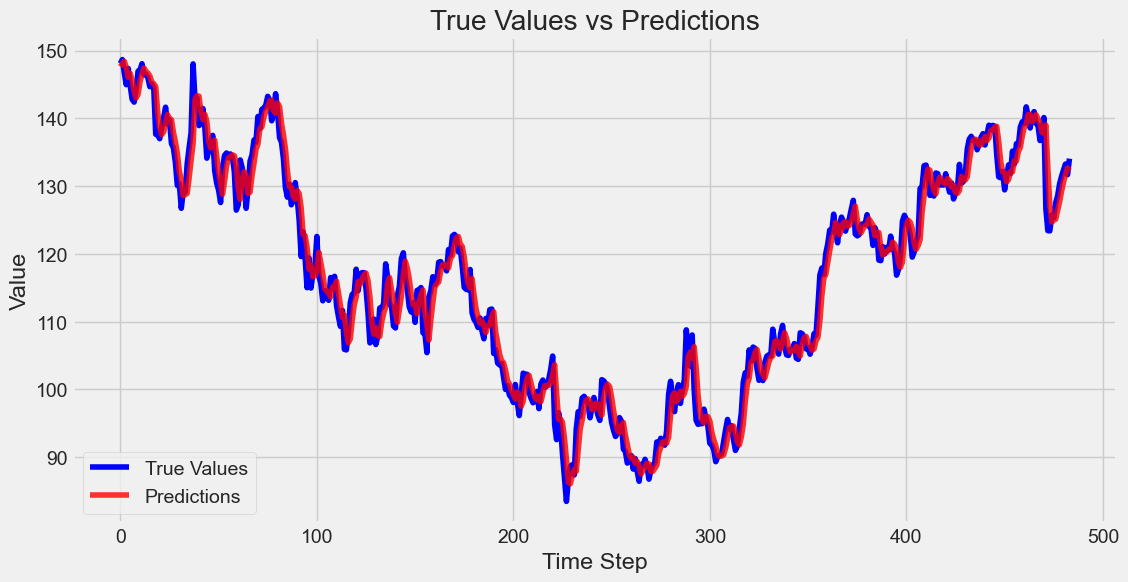

In [10]:

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(predicted_residuals_gru, label='Predictions', color='red', alpha=0.8)
plt.title('True Values vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


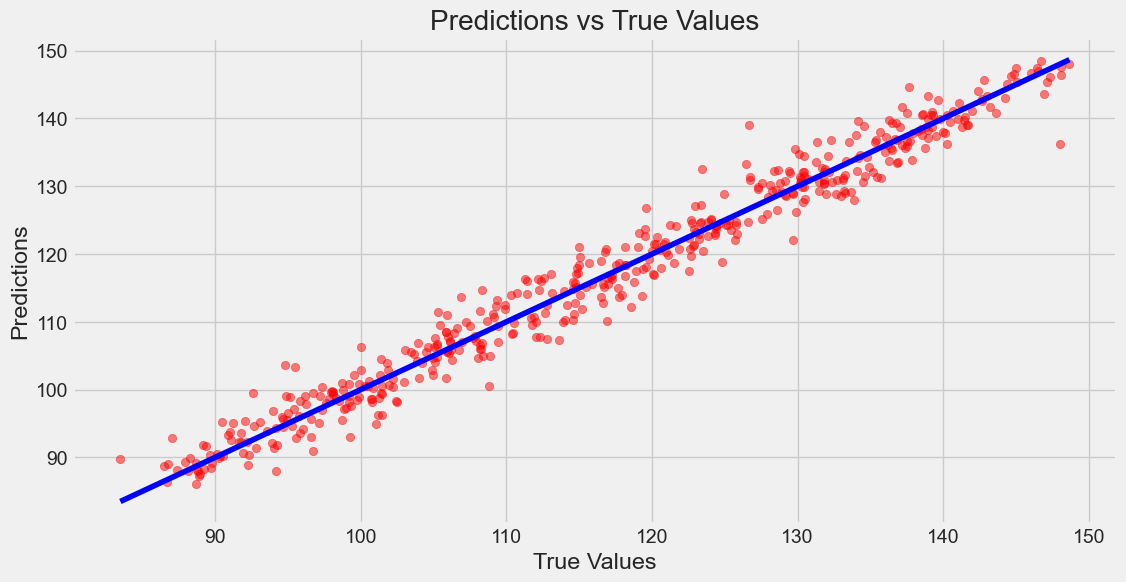

In [13]:

plt.figure(figsize=(12, 6))
plt.scatter(y_test, predicted_residuals_gru, color='red',alpha=0.5)
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue') 
plt.show()
